In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import utils.utils as utils
from utils.models import LeNet, DDNet
from utils.interp_attacks import InterpAttacker
from utils.data_loaders import DataLoader

# makes default tensor a CUDA tensor so GPU can be used
device = torch.device(2 if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if device != 'cpu':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

### Load network to attack and create Dataloader 

```net1``` is the original, undefended network, and ```net1_proxy``` is the undefended network's counterpart that we use to create the attack for ```net1```. ```net1_proxy``` is only different from ```net1``` in its activations: the softplus activation function of ```net1_proxy``` is second-order differentiable, unlike the relu activation function in ```net1```. 

```net2``` is a defended network, and similarly, ```net2_proxy``` is the defended network's counterpart that we use to create the attack for ```net2```. Again, ```net2_proxy``` is only different from ```net2``` in its activations.

In [24]:
dataset = 'CIFAR-10'

if dataset == 'CIFAR-10':
    NET = DDNet
    net1_name = f'trained_models/CIFAR-10/training_round_1/ir10_ir20_scale0.1'
    # net2_name = f'trained_models/CIFAR-10/training_round_2/CIFAR-10_ir10.001_scale0.1_2'
    net2_name = f'trained_models/CIFAR-10/training_round_2/CIFAR-10_ir10.06_scale0.1_2'
else:
    NET = LeNet
    net1_name = f'trained_models/MNIST/training_round_{2}/ep{0}_wd{0}_jr{0}_{2}'
    # net2_name = f'trained_models/training_round_{2}/ep{0}_wd{0}_jr{0.01}_{2}'
    # net2_name = f'trained_models/interp_reg_tests/jr{.001}_ir{200.}'
    # net2_name = f'trained_models/MNIST/interp_reg_tests/jr{.01}_ir1{10}_ir2{0}_scale{.1}'
    net2_name = f'trained_models/MNIST/interp_reg_tests2/MNIST_ir10.01_scale0.15'

net1 = NET(activation=torch.nn.functional.relu)
net1_proxy = NET(activation=torch.nn.functional.softplus)

net2 = NET(activation=torch.nn.functional.relu)
net2_proxy = NET(activation=torch.nn.functional.softplus)

net1.load_state_dict(torch.load(net1_name))
net1_proxy.load_state_dict(torch.load(net1_name))
net2.load_state_dict(torch.load(net2_name))
net2_proxy.load_state_dict(torch.load(net2_name))

# put each model in evaluation mode. i.e. turn off dropout layers, etc.
net1.eval()
net1_proxy.eval()
net2.eval()
net2_proxy.eval()

dl = DataLoader(dataset=dataset, tr_batch_size=1, augment=False)
train_loader = dl.train_loader

Files already downloaded and verified
Files already downloaded and verified


### Display the original and perturbed samples and the corresponding saliency maps

In [33]:
sample,label = next(iter(train_loader))
sample,label = sample.to(device),label.to(device)

# define a target for the targeted attack
target = torch.eye(32)

try:
    sga1 = InterpAttacker(net1, sample, label, net_proxy=net1_proxy, k=100, target=target)
    sga2 = InterpAttacker(net2, sample, label, net_proxy=net2_proxy, k=100, target=target)

    # perform attack on both networks using sample as a starting point and track number of iterations performed
    sample_1, best_i1, iters1, confidence1 = sga1.iterative_attack(sample, attack_method='targeted', 
                                                interp_to_attack='simple_gradient', measure='intersection', 
                                                alpha=.005, num_iters=300, invert=False)
    sample_2, best_i2, iters2, confidence2 = sga2.iterative_attack(sample, attack_method='targeted', 
                                                interp_to_attack='simple_gradient', measure='intersection', 
                                                alpha=.005, num_iters=300, invert=False)

    # create saliency map for each adversarial example
    saliency_map_1 = sga1.interp_generator(net1, sample_1, label, used=False)
    saliency_map_2 = sga2.interp_generator(net2, sample_2, label, used=False)
except Exception as e:
    print(repr(e))

net1(sample) = net2(sample) = 0

net1(sample_1) = 0
	confidence: 0.913118
	iters used to create: 251
	best sample from iter 118
net2(sample_2) = 0
	confidence: 0.765085
	iters used to create: 299
	best sample from iter 250


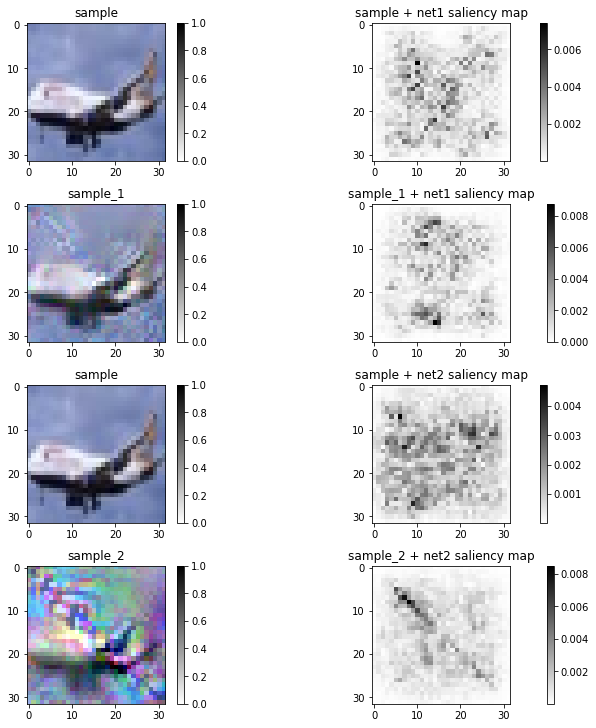

In [34]:
fig = plt.figure(figsize=(10,10), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=4, figure=fig)

print(f'net1(sample) = net2(sample) = {label.item()}\n')
print(f'net1(sample_1) = {torch.argmax(net1(sample_1))}\n\tconfidence: {confidence1:4f}')
print(f'\titers used to create: {iters1}\n\tbest sample from iter {best_i1}')
print(f'net2(sample_2) = {torch.argmax(net2(sample_2))}\n\tconfidence: {confidence2:4f}')
print(f'\titers used to create: {iters2}\n\tbest sample from iter {best_i2}')

if dataset == 'CIFAR-10':
    sample = utils.rescale(sample.squeeze().permute(1,2,0))
    sample_1 = utils.rescale(sample_1.squeeze().permute(1,2,0))
    sample_2 = utils.rescale(sample_2.squeeze().permute(1,2,0))

ax1 = fig.add_subplot(spec[0,0])
ax1.title.set_text('sample')
plt.imshow(sample.squeeze().cpu().numpy(), cmap='binary')
plt.colorbar()

ax2 = fig.add_subplot(spec[0,1])
ax2.title.set_text('sample + net1 saliency map')
plt.imshow(sga1.og_saliency.squeeze().cpu().detach().numpy(), cmap='binary')
plt.colorbar()

ax3 = fig.add_subplot(spec[1,0])
ax3.title.set_text('sample_1')
plt.imshow(sample_1.squeeze().cpu().numpy(), cmap='binary')
plt.colorbar()

ax4 = fig.add_subplot(spec[1,1])
ax4.title.set_text('sample_1 + net1 saliency map')
plt.imshow(saliency_map_1.squeeze().cpu().detach().numpy(), cmap='binary')
plt.colorbar()

ax5 = fig.add_subplot(spec[2,0])
ax5.title.set_text('sample')
plt.imshow(sample.squeeze().cpu().numpy(), cmap='binary')
plt.colorbar()

ax6 = fig.add_subplot(spec[2,1])
ax6.title.set_text('sample + net2 saliency map')
plt.imshow(sga2.og_saliency.squeeze().cpu().detach().numpy(), cmap='binary')
plt.colorbar()

ax5 = fig.add_subplot(spec[3,0])
ax5.title.set_text('sample_2')
plt.imshow(sample_2.squeeze().cpu().numpy(), cmap='binary')
plt.colorbar()

ax6 = fig.add_subplot(spec[3,1])
ax6.title.set_text('sample_2 + net2 saliency map')
plt.imshow(saliency_map_2.squeeze().cpu().detach().numpy(), cmap='binary')
plt.colorbar()

plt.show()

#### CIFAR-10 class labels
<font size="1"> 
    airplane : 0,
    automobile : 1,
    bird : 2,
    cat : 3,
    deer : 4,
    dog : 5,
    frog : 6,
    horse : 7,
    ship : 8,
    truck : 9
</font>

### Determine norm of difference between original and perturbed sample saliency maps

```sample``` is the original sample and ```label``` is the correct label associated with it.

Each variable that has a "2" in its name is ```net2```'s version of the variable.

```InterpAttacker.og_saliency``` is the saliency map associated with the original, unperturbed input sample for each network.

We would like to determine if the saliency maps for ```net2``` are less malleable than those produced by ```net1```.

In [ ]:
# each list will contain the norms of the difference between original and perturbed sample saliency maps for each net
net1_norms = []
net2_norms = []

for i in range(200):
    if i % 10 == 0:
        print(f'attacking sample {i}')
        
    sample,label = next(iter(train_loader))
    sample,label = sample.to(device),label.to(device)

    # the target saliency map will be a 28x28 identity matrix
    target = torch.eye(28)
    sga1 = InterpretationAttacker(net1, net1_proxy, sample, label, top_k=100, target=target)
    sga2 = InterpretationAttacker(net2, net2_proxy, sample, label, top_k=100, target=target)
    
    # if either network makes incorrect prediction on original sample, skip to next sample
    if not sga1.can_attack or not sga2.can_attack:
        continue
    
    # perform attack on both networks using sample as a starting point and track number of iterations performed
    sample_1, iters1 = sga1.iterative_attack(sample, attack_method='mass-center', alpha=.001, num_iters=500)
    sample_2, iters2 = sga2.iterative_attack(sample, attack_method='mass-center', alpha=.001, num_iters=500)
    
    # create saliency map for each adversarial example
    saliency_map_1 = sga1.interpretation_generator(net1, sample_1, label, used=False)
    saliency_map_2 = sga2.interpretation_generator(net2, sample_2, label, used=False)
    
    # find norm of difference between original and perturbed sample saliency maps and scale this norm by the 
    # number of iterations taken to create the adversarial sample
    net1_norms.append(torch.norm(sga1.og_saliency - saliency_map_1).item() / iters1)
    net2_norms.append(torch.norm(sga2.og_saliency - saliency_map_2).item() / iters2)

print(f'average, scaled norm of difference between original and perturbed sample\'s saliency maps:')
print(f'\toriginal network: {sum(net1_norms) / len(net1_norms)}')
print(f'\tdefended network: {sum(net2_norms) / len(net2_norms)}')